In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import glob

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from PIL import Image
from IPython import display
%matplotlib inline

Upload the data

In [2]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files'
os.listdir(path)

['H79_F108_csv_annot_csv_KH.csv',
 'H79_F125_csv_annot MISSING H8_OM_KH.csv',
 'H81_F158_csv_annot_KH.csv',
 'H81_F171_csv_annot.csv',
 'H81_F171_csv_annot_OM_KH.csv',
 'H82_F111_csv_annotOM_KH.csv',
 'H96_F61_csv_annot.csv',
 'H96_F88_csv_annot.csv']

In [4]:
data_list = []
for filename in glob.glob(os.path.join(path, '*.csv')):
    if filename != r'C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H81_F171_csv_annot.csv':
        data = pd.read_csv(filename, header=0)
        print(filename, data.shape)
        data_list.append(data)

C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H79_F108_csv_annot_csv_KH.csv (8270, 384)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H79_F125_csv_annot MISSING H8_OM_KH.csv (8775, 384)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H81_F158_csv_annot_KH.csv (8138, 384)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H81_F171_csv_annot_OM_KH.csv (10173, 384)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H82_F111_csv_annotOM_KH.csv (10173, 384)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H96_F61_csv_annot.csv (8138, 384)
C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files\H96_F88_csv_annot.csv (8138, 384)


Split to three classes, electrode

In [50]:
drivers = []
nondrivers = []
noises = []

for df in data_list:
    driver = pd.DataFrame()
    nondriver = pd.DataFrame()
    noise = pd.DataFrame()
    for col in df.columns[1::3]:
        curr_index = list(df.columns).index(col)
        prev_index = curr_index - 1
        next_index = curr_index + 1
        prev_col = df.iloc[:,prev_index]
        next_col = df.iloc[:,next_index]
        if df[col][0] == 1:
            driver[df.columns[prev_index]] = prev_col
            driver[df.columns[next_index]] = next_col
        elif df[col][0] == 0:
            nondriver[df.columns[prev_index]] = prev_col
            nondriver[df.columns[next_index]] = next_col
        elif df[col][0] == -1:
            noise[df.columns[prev_index]] = prev_col
            noise[df.columns[next_index]] = next_col
    drivers.append(driver)
    nondrivers.append(nondriver)
    noises.append(noise)

# Fourier transform

In [51]:
path = r'C:\Users\ecath\Desktop\Research\Raw Data\Ex Vivo CSV Files'
path1 = r'C:\Users\ecath\Desktop\Research\Raw Data\FFT_imgs'

In [52]:
def kill_nul(df):
    df.fillna(value=0, axis=1, inplace=True)
    for col in df.columns:
        if df[col].sum() == 0:
            df.drop([col], axis = 1, inplace = True)  
    return df

In [238]:
def concat_fft(df, N, T):
    fft_out = pd.DataFrame()
    for col in df.columns:
        fft_yf =  np.fft.fft(df[col])
        fft_xf = np.fft.fftfreq(N, T)

        fft_xf_20 = fft_xf[np.argwhere((fft_xf<20) & (fft_xf>0))]
        fft_yf_20 = fft_yf[np.argwhere((fft_xf<20) & (fft_xf>0))]

        fft_yf_20 = pd.DataFrame(np.abs(fft_yf_20)/N, columns=[col + '_yf'])
        fft_xf_20 = pd.DataFrame(fft_xf_20, columns=[col + '_xf']) 
        fft_20 = pd.concat([fft_yf_20, fft_xf_20], axis=1)

        fft_out = pd.concat([fft_out, fft_20], axis=1)
    return(fft_out)

In [244]:
def full_fft_list(class_df):
    all_fft_el = []
    all_fft_om = []

    for k, df in enumerate(class_df):
        electrode_signal = df[df.columns[::2]]
        optical_signal = df[df.columns[1::2]]

        kill_nul(optical_signal)

        N = df.shape[0] # Number of sample points
        Fs_el = 1017.25 # sampling rate
        Fs_om = 1000.0
        T_el = 1.0/Fs_el
        T_om = 1.0/Fs_om

        fft_el = concat_fft(electrode_signal, N, T_el)
        all_fft_el.append(fft_el)

        fft_om = concat_fft(optical_signal, N, T_om)
        all_fft_om.append(fft_om)
    return(all_fft_el, all_fft_om)


In [416]:
def fft_creation_el(dataframe, label):
    all_fft_el, _ = full_fft_list(dataframe)
    
    m=[]
    
    for i in range(len(all_fft_el)):
        m.append(all_fft_el[i].shape[0])
    # print(np.max(m))

    for i in range(len(all_fft_el)):
        mx = np.max(m) - all_fft_el[i].shape[0]
#         print(mx)
        zeros = np.zeros(shape = (mx, all_fft_el[i].shape[1]))
#         print(zeros.shape)
        zeros = pd.DataFrame(zeros, columns=all_fft_el[i].columns, index=np.arange(all_fft_el[i].shape[0], np.max(m)))
        all_fft_el[i] = all_fft_el[i].append(zeros)
#         print(all_fft_el[i].shape)
        target = np.full(shape=(1, all_fft_el[i].shape[1]), fill_value = label)
#         print(target.shape)
        target = pd.DataFrame(target, columns=all_fft_el[i].columns, index=['target'])
#         print(target.shape)
        all_fft_el[i] = all_fft_el[i].append(target)
#         print(all_fft_el[i].shape)
    
    all_fft = pd.DataFrame()
    
    for i in range(len(all_fft_el)):
        all_fft = pd.concat([all_fft, all_fft_el[i]], axis=1)
#         print(all_fft_el[i].shape)
#         print(all_fft.shape)
    return(all_fft)


In [413]:
def fft_creation_om(dataframe, label):
    _, all_fft_om = full_fft_list(dataframe)
    
    m=[]
    
    for i in range(len(all_fft_om)):
        m.append(all_fft_om[i].shape[0])
    # print(np.max(m))

    for i in range(len(all_fft_om)):
        mx = np.max(m) - all_fft_om[i].shape[0]
#         print(mx)
        zeros = np.zeros(shape = (mx, all_fft_om[i].shape[1]))
#         print(zeros.shape)
        zeros = pd.DataFrame(zeros, columns=all_fft_om[i].columns, index=np.arange(all_fft_om[i].shape[0], np.max(m)))
        all_fft_om[i] = all_fft_om[i].append(zeros)
#         print(all_fft_el[i].shape)
        target = np.full(shape=(1, all_fft_om[i].shape[1]), fill_value = label)
#         print(target.shape)
        target = pd.DataFrame(target, columns=all_fft_om[i].columns, index=['target'])
#         print(target.shape)
        all_fft_om[i] = all_fft_om[i].append(target)
#         print(all_fft_el[i].shape)
    
    all_fft = pd.DataFrame()
    
    for i in range(len(all_fft_om)):
        all_fft = pd.concat([all_fft, all_fft_om[i]], axis=1)
#         print(all_fft_el[i].shape)
#         print(all_fft.shape)
    return(all_fft)


In [420]:
a = fft_creation_el(drivers, 1)
b = fft_creation_el(nondrivers, 0)
c = fft_creation_el(noises, -1) 

final = pd.concat([a, b, c], axis=1)
final.to_csv(path + '\All FFT of electrode signal.csv', sep=',', index=True)

C:\Users\ecath\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\ecath\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [424]:
a = fft_creation_om(drivers, 1)
b = fft_creation_om(nondrivers, 0)
c = fft_creation_om(noises, -1) 

final = pd.concat([a, b, c], axis=1)
final.to_csv(path + '\All FFT of optical signal.csv', sep=',', index=True)

C:\Users\ecath\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\ecath\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [429]:
x = pd.read_csv(path + '\All FFT of electrode signal.csv', index_col=0)
x.head()

,Bsk 1 B5_yf,Bsk 1 B5_xf,Bsk 1 C5_yf,Bsk 1 C5_xf,Bsk 1 C6_yf,Bsk 1 C6_xf,Bsk 2 D4_yf,Bsk 2 D4_xf,Bsk 2 D5_yf,Bsk 2 D5_xf,...,Bsk 2 B1_yf.6,Bsk 2 B1_xf.6,Bsk 2 D8_yf.6,Bsk 2 D8_xf.6,Bsk 2 E4_yf.6,Bsk 2 E4_xf.6,Bsk 2 E8_yf.6,Bsk 2 E8_xf.6,Bsk 2 H1_yf.6,Bsk 2 H1_xf.6
0,0.003676,0.123005,0.003333,0.123005,0.001764,0.123005,0.003290,0.123005,0.001552,0.123005,...,0.164997,0.125,0.015260,0.125,0.164997,0.125,0.174698,0.125,0.004937,0.125
1,0.004131,0.246010,0.002713,0.246010,0.001222,0.246010,0.002135,0.246010,0.000852,0.246010,...,0.333983,0.250,0.005516,0.250,0.333983,0.250,0.090301,0.250,0.010578,0.250
2,0.005600,0.369015,0.001612,0.369015,0.001206,0.369015,0.003501,0.369015,0.000807,0.369015,...,0.282372,0.375,0.010082,0.375,0.282372,0.375,0.054344,0.375,0.008207,0.375
3,0.004800,0.492019,0.002527,0.492019,0.001257,0.492019,0.003584,0.492019,0.002303,0.492019,...,0.182682,0.500,0.011114,0.500,0.182682,0.500,0.029982,0.500,0.006823,0.500
4,0.007835,0.615024,0.004176,0.615024,0.002486,0.615024,0.006998,0.615024,0.002106,0.615024,...,0.170138,0.625,0.005471,0.625,0.170138,0.625,0.036335,0.625,0.004820,0.625


In [430]:
y = pd.read_csv(path + '\All FFT of optical signal.csv', index_col=0)
y.head()

,Bsk.18_yf,Bsk.18_xf,Bsk.22_yf,Bsk.22_xf,Bsk.26_yf,Bsk.26_xf,Bsk.34_yf,Bsk.34_xf,Bsk.1_yf,Bsk.1_xf,...,Bsk.21_yf.2,Bsk.21_xf.2,Bsk_yf.2,Bsk_xf.2,Bsk.2_yf.2,Bsk.2_xf.2,Bsk.9_yf.2,Bsk.9_xf.2,Bsk.29_yf.1,Bsk.29_xf.1
0,13.305319,0.113960,13.401476,0.113960,12.949848,0.113960,14.284878,0.113960,10.301577,0.098299,...,11.044729,0.098299,7.236684,0.098299,9.155327,0.098299,8.051086,0.098299,7.042802,0.098299
1,2.112700,0.227920,1.475760,0.227920,1.769940,0.227920,1.869678,0.227920,6.913201,0.196599,...,6.609004,0.196599,6.858546,0.196599,5.743818,0.196599,6.551286,0.196599,6.096596,0.196599
2,3.814463,0.341880,4.389986,0.341880,3.707692,0.341880,4.244925,0.341880,4.133573,0.294898,...,4.566608,0.294898,4.162986,0.294898,3.535936,0.294898,4.652497,0.294898,4.444352,0.294898
3,1.419155,0.455840,1.350635,0.455840,1.445948,0.455840,1.575148,0.455840,2.879320,0.393198,...,2.937244,0.393198,2.374495,0.393198,3.344770,0.393198,2.513651,0.393198,2.189380,0.393198
4,2.021158,0.569801,2.672232,0.569801,2.168010,0.569801,2.318364,0.569801,1.921207,0.491497,...,1.596622,0.491497,0.091972,0.491497,0.816747,0.491497,0.812799,0.491497,0.364056,0.491497


In [410]:
all_fft_el, all_fft_om = full_fft_list(drivers)

C:\Users\ecath\Anaconda3\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\ecath\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


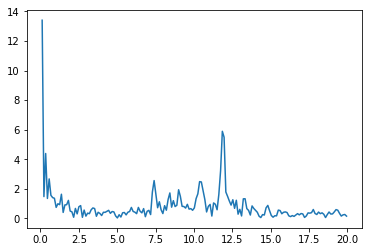

In [412]:
plt.plot(all_fft_om[1].iloc[:,1], all_fft_om[1].iloc[:,2])